Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.


Importing all the important libraries


In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
!pip install keras

Importing Data

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Define the path of train and test image
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Load using keras.preprocessing


Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**

Define some parameters for the loader:

In [8]:
batch_size=32
img_height=180
img_width=180

Use 80% of the images for training, and 20% for validation.



In [9]:
## train dataset
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset='training',
  image_size=(img_height,img_width),
  batch_size=batch_size

)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## validation dataset
val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names=train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Visualize the data

Below is the code to visualize one instance of all the nine classes present in the dataset


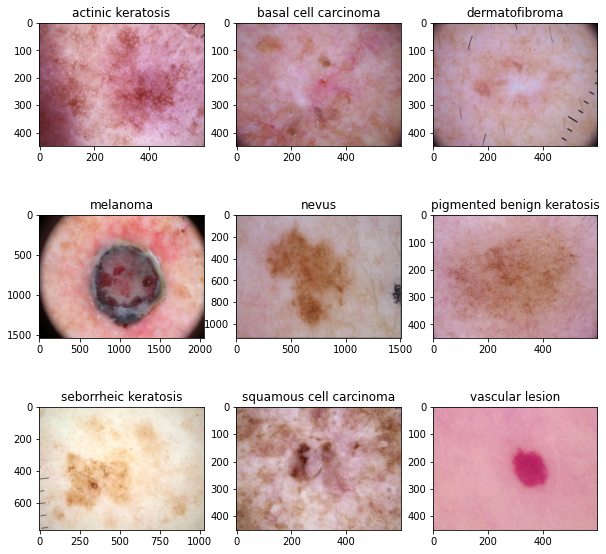

In [12]:
import matplotlib.image as mpimg
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image=mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.



Dataset.prefetch() overlaps data preprocessing and model execution while training.



In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create the model

Below is the first base model`we have created

In [14]:
from keras.layers import Dense ,Dropout , Flatten ,Conv2D ,MaxPool2D
num_classes=9
model=Sequential([
                  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3))
                  ])
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='Same',
                 activation='relu',input_shape=(180,180,32)))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='Same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='Same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='Same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))



**Compile the model**<br>
Choose an appropirate optimiser and loss function for model training 

In [15]:
from tensorflow.keras.optimizers import RMSprop


As it is a multi class classification, we are using SparseCategoricalCrossEntropy as the loss function, and we are using adam optimizer as a hit & trial, further we can perform hyper parameter optimization and change the optimizer accordingly

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# view the summary of all the layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 32)        2

### *Training the model*

In [18]:
epochs=30
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


56/56 [==============================] - 235s 844ms/step - loss: 2.0640 - accuracy: 0.1925 - val_loss: 2.0540 - val_accuracy: 0.2170
Epoch 2/30
56/56 [==============================] - 8s 148ms/step - loss: 2.0314 - accuracy: 0.1998 - val_loss: 2.0279 - val_accuracy: 0.2058
Epoch 3/30
56/56 [==============================] - 8s 147ms/step - loss: 2.0209 - accuracy: 0.1953 - val_loss: 2.0008 - val_accuracy: 0.2170
Epoch 4/30
56/56 [==============================] - 8s 146ms/step - loss: 1.9783 - accuracy: 0.2427 - val_loss: 1.9561 - val_accuracy: 0.2237
Epoch 5/30
56/56 [==============================] - 8s 146ms/step - loss: 1.9550 - accuracy: 0.2433 - val_loss: 1.9577 - val_accuracy: 0.2394
Epoch 6/30
56/56 [==============================] - 8s 146ms/step - loss: 1.9605 - accuracy: 0.2422 - val_loss: 1.9546 - val_accuracy: 0.2461
Epoch 7/30
56/56 [==============================] - 8s 146ms/step - loss: 1.9665 - accuracy: 0.2305 - val_loss: 1.8978 - val_accuracy: 0.3423
Epoch 8/30
56/5

Visualizing training results

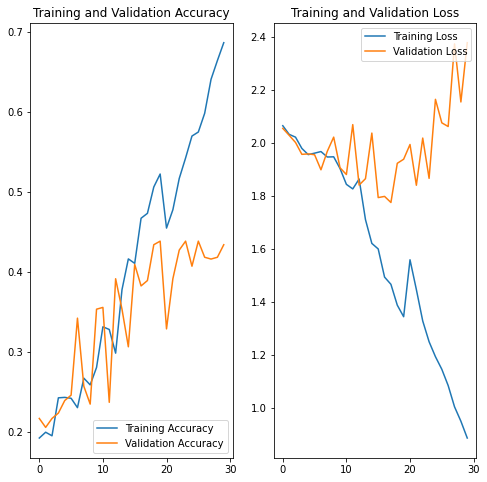

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings on the first base model**<br>


*   Initial findings: The model is overfitting because overfitting is calculated w.
r.t loss, and we can also see difference in loss functions in training & test 
around the 19-20th epoch
*   The accuracy is just around 50-60% because there are enough features to remember the pattern, and the neural network is very young (just 20 epochs), so the learning has just started
*  But again, it's too early to comment on the overfitting & underfitting debate

In [20]:
data_aug=keras.Sequential([
                           layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                           layers.experimental.preprocessing.RandomRotation(0.2,fill_mode='reflect'),
                           layers.experimental.preprocessing.RandomZoom(height_factor=(0.2,0.3),width_factor=(0.2,0.3),fill_mode='reflect')])

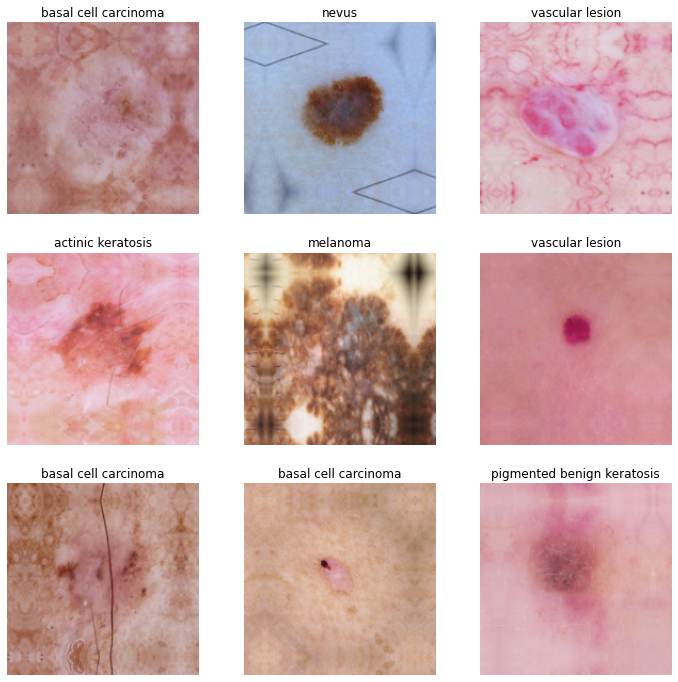

In [21]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Model Creation, compilation and training model

In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


Compiling the model

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


56/56 [==============================] - 10s 156ms/step - loss: 2.0574 - accuracy: 0.1992 - val_loss: 2.0324 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 8s 152ms/step - loss: 2.0618 - accuracy: 0.2104 - val_loss: 2.0805 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 8s 151ms/step - loss: 2.0444 - accuracy: 0.2154 - val_loss: 2.0279 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 9s 152ms/step - loss: 2.0249 - accuracy: 0.1903 - val_loss: 2.0267 - val_accuracy: 0.2081
Epoch 5/20
56/56 [==============================] - 8s 152ms/step - loss: 2.0638 - accuracy: 0.1920 - val_loss: 2.1014 - val_accuracy: 0.2036
Epoch 6/20
56/56 [==============================] - 8s 151ms/step - loss: 2.0279 - accuracy: 0.1897 - val_loss: 2.0267 - val_accuracy: 0.2036
Epoch 7/20
56/56 [==============================] - 8s 152ms/step - loss: 2.0209 - accuracy: 0.1948 - val_loss: 2.0332 - val_accuracy: 0.2058
Epoch 8/20
56/56

Visualizing the data

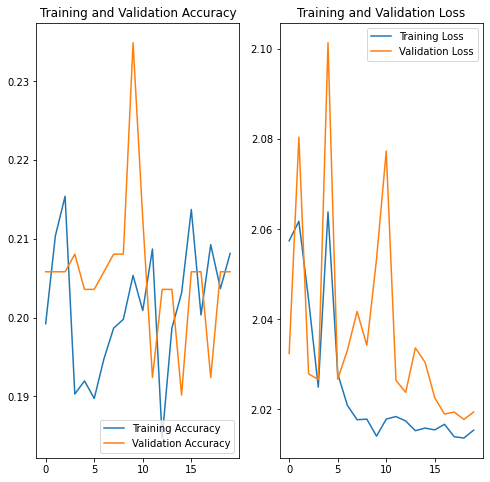

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings:**

* We don't see much improvements with respect to accuracy from the base model, but we can definitely see the overfitting issue fading away due to data augmentation

* But again, judging based on just 20 epochs won't give us proper conclusions

Finding the distribution of classes in the training dataset

In [28]:
path_list=[]
lesion_list=[]
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)

dataframe_dict_original=dict(zip(path_list,lesion_list))
original_df=pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2235,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2236,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2237,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion


In [29]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df


,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2235,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2236,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2237,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion


<BarContainer object of 9 artists>

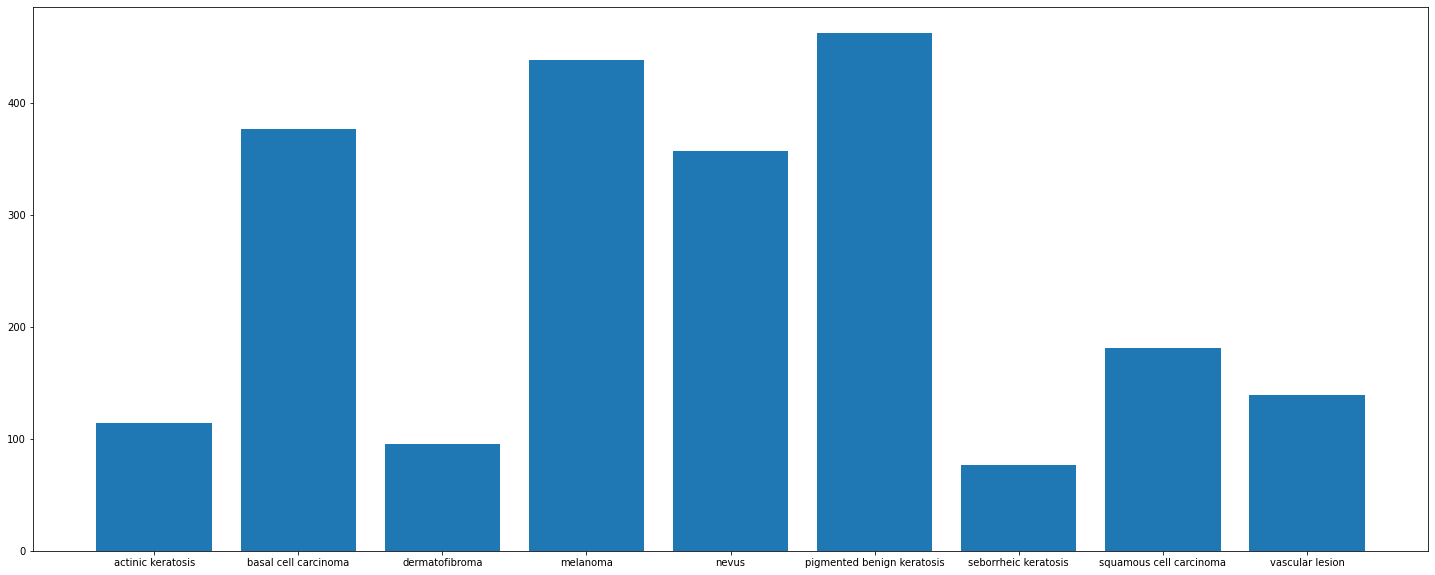

In [30]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

**Findings**


*  Seborrheic keratosis is having the lowest distribution

*  Pigmented Benign keratosis is having the highest distribution of data




Visualize the model results


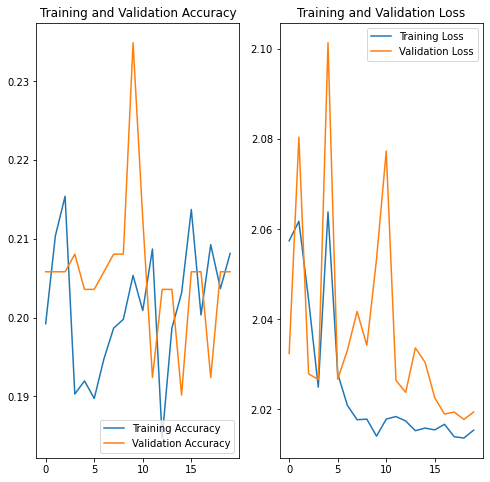

In [31]:

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
!pip install Augmentor

In [38]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F061737ED10>: 100%|██████████| 500/500 [00:22<00:00, 22.29 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F068D3E4AD0>: 100%|██████████| 500/500 [00:23<00:00, 21.70 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F068D34E910>: 100%|██████████| 500/500 [00:22<00:00, 21.93 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2592x1944 at 0x7F068D390090>: 100%|██████████| 500/500 [01:48<00:00,  4.60 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F077F77D2D0>: 100%|██████████| 500/500 [01:37<00:00,  5.15 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F068D400FD0>: 100%|██████████| 500/500 [00:22<00:00, 21.95 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F0616AEAF10>: 100%|██████████| 500/500 [00:49<00:00, 10.03 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F068D3E7CD0>: 100%|██████████| 500/500 [00:22<00:00, 22.01 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F068D31D3D0>: 100%|██████████| 500/500 [00:23<00:00, 21.17 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types..<br> Lets take a look at total count of augmented images.

In [39]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [42]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_d5406b76-5b77-4fd4-875a-af7902f1de47.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026457.jpg_8a548c1b-4dff-4cf4-b165-a44952ed81c5.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027172.jpg_e9f91738-5d80-45f6-826c-6688f58dd03d.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030036.jpg_fba984d2-ed5b-4b7d-8b34-3b00f770d140.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029840.jpg_43cd9aa2-d814

In [43]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [45]:
path_list_new=path_list
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [46]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [47]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Train the model on the data created using Augmentor

In [48]:
batch_size = 32
img_height = 180
img_width = 180

Create a training dataset

In [49]:
data_dir_train="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Create a validation dataset

In [52]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [55]:
model = Sequential([
  data_aug,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.BatchNormalization(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])



 Compile your model

In [56]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

 Train your model

In [57]:
epochs=50
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


169/169 [==============================] - 44s 239ms/step - loss: 1.8046 - accuracy: 0.3705 - val_loss: 3.4462 - val_accuracy: 0.1492
Epoch 2/50
169/169 [==============================] - 40s 232ms/step - loss: 1.4050 - accuracy: 0.4655 - val_loss: 2.4024 - val_accuracy: 0.3437
Epoch 3/50
169/169 [==============================] - 40s 230ms/step - loss: 1.2797 - accuracy: 0.5172 - val_loss: 1.2378 - val_accuracy: 0.5286
Epoch 4/50
169/169 [==============================] - 40s 229ms/step - loss: 1.2150 - accuracy: 0.5371 - val_loss: 1.2283 - val_accuracy: 0.5620
Epoch 5/50
169/169 [==============================] - 40s 230ms/step - loss: 1.1245 - accuracy: 0.5796 - val_loss: 1.1805 - val_accuracy: 0.5590
Epoch 6/50
169/169 [==============================] - 41s 237ms/step - loss: 1.0841 - accuracy: 0.5855 - val_loss: 1.3196 - val_accuracy: 0.5004
Epoch 7/50
169/169 [==============================] - 41s 237ms/step - loss: 1.0284 - accuracy: 0.6098 - val_loss: 1.0750 - val_accuracy: 0.5

**ACCURACY='87%'**<BR>   **VALLIDATION_ACCURACY='81%'**
*  **The model is not overfitting and due to augmentation the accuracy has significantly increased**


*  **Yes class rebalance helped here, as its important to balance out the data set or at least get it close to balance it in**

